### Objective: To apply Decision Tree on amazon fine food reviews

In [1]:
!pip install scikit-plot

In [2]:
!pip install pydotplus

In [0]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from IPython.display import display
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from graphviz import Source

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [7]:
# SOURCE: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=zU5b6dlRwUQk
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 20.4MB/s 


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Load a file by ID and print its contents.

downloaded = drive.CreateFile({'id':'18Xh1M86f54Fb-42Z8g2MbXw8y8OuNZx_'}) 
downloaded.GetContentFile('Reviews.CSV')

customer_reviews = pd.read_csv('Reviews.CSV')

In [10]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [11]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [12]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [13]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [14]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [15]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [16]:

# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [18]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'do', "didn't", 'which', "don't", 'those', 'been', "wouldn't", 'being', 'only', "shan't", 'herself', 'itself', 'a', 'before', 't', 'then', 'needn', 'at', 'it', 'very', 'once', 'and', 'i', 'have', 'had', 'as', 'other', 'y', 'there', 'haven', 'down', 'themselves', 'm', 've', 'same', 'them', "haven't", 'hadn', 'your', 'did', 'what', 'such', 'on', 'above', 'their', 'how', "hadn't", 'why', "it's", 'didn', "you'll", 'to', "aren't", 'shan', "isn't", 'should', 'd', 're', "won't", 'couldn', 'my', 'but', 'these', "wasn't", 'having', 'too', 'yourself', 'himself', 'most', 'her', 'more', 'has', 'nor', 'wouldn', 'isn', 'up', "that'll", 'for', 'won', 'where', 'doesn', "you're", 'in', 'when', 'me', 'about', 'into', 'its', 'while', 'they', 'during', 'can', 'wasn', 'of', 'yours', 'all', 'whom', 'again', 'out', 'than', 'be', 'through', 'between', 'with', 'yourselves', 'that', 'does', 'is', 'she

In [0]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


In [20]:
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [0]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
            
        

In [22]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [23]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g...",love book miss hard cover version grew read se...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...,chicken soup rice month fun way children learn...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...,good swingi rhythm read aloud great littl book...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...,great way learn month book poetri month year g...


### Observation:
Dataset is highly imbalanced. Out of 364171 reviews only 57110 reviews are negative and rest are positive. 
 

In [0]:
# sorting whole  data based on time
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)

#sampled_data.sort_values('Time',axis=0,kind="quicksort", ascending=True , inplace = True)

In [25]:
b.head(20) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like books or movies.

In [0]:
# removing reviews that belong to other products
regex =  re.compile(r'book|entertaining|funny|movie|show|film|series|educational|storyteller|comedic') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )

In [27]:
# Number of reviews left
b.shape

(353205, 12)

In [28]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


Checking if text length could be used as a feature for calssification

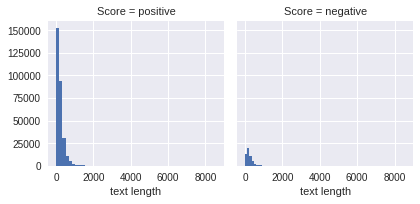

In [29]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)
plt.show()

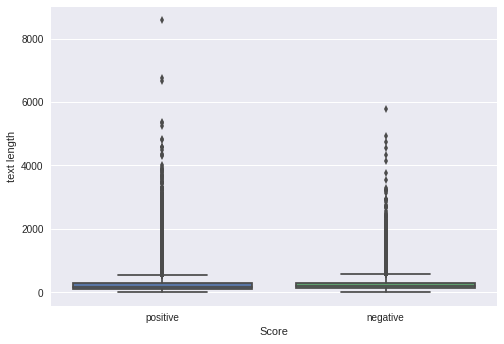

In [30]:
sns.boxplot(x='Score', y='text length', data=b)
plt.show()

It seems clearer from above plots that text length  won't be a helpful featurer for classification

### Function for standardizing data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:

def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [0]:
# taking top 60k points from whole dataset
sampled_data = b.head(60000)

In [34]:
sampled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


In [35]:
sampled_data['text length']

76881      172
374449     633
1244       116
1243       250
131216     275
149769     152
149788     108
149767     198
374448     347
149791     138
374334     321
361316     399
479722     356
479729     252
361308     423
374356     177
479727     379
479723     367
149784     490
361310     141
149786      56
149700     351
149701     592
149699     334
245107     875
149785     320
479724     240
361309     606
479735     113
374327     157
          ... 
44574       64
182308     214
118457     293
527411     117
100089     779
38820      689
68902      157
548458     618
55110       86
526298     485
255640     187
436927    1018
55109      113
287705     217
5521       317
271367     223
514618     189
167851     168
117690     218
542079      86
451021     113
363406     377
257116     168
489704      94
430732     433
6353        99
10784      255
546589     202
322715     208
148681     584
Name: text length, Length: 60000, dtype: int64

In [0]:
# breaking data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1
    else:
        return -1
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test  , len_train , len_test= train_test_split(sampled_data['CleanedText'],sampled_data['Score'],sampled_data['text length'] ,test_size=0.3, random_state=45)

In [37]:
Y_train.value_counts()

 1    37193
-1     4807
Name: Score, dtype: int64

## Bag of Words

#### Vectorizing & Standarzing both train and test data

In [38]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,2) , dtype = 'float' ,min_df = 5 , max_df = 0.5) # considering only relevent words
# min_df--> ignoring terms that appear in less than 9 documents
#max_df---> ignore terms that appear in more than 60% documents

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (42000, 56119)
Test Dataset:  (18000, 56119)


In [0]:
# standarzing both train and test matrix 
bow_std_X_train_matrix = std_data(bow_X_train_matrix)
bow_std_X_test_matrix = std_data(bow_X_test_matrix)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
# taking different values of depth
depth = list( x for x in range(5,30,5) )
depth

[5, 10, 15, 20, 25]

In [42]:
# cross validation using gridsearch
clf = DecisionTreeClassifier()
param_grid = {'max_depth':depth} 
tscv = TimeSeriesSplit(n_splits=5) # time based splitting
dt_using_grid = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1' ,n_jobs = -1)
dt_using_grid.fit(bow_std_X_train_matrix,Y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [43]:
# checking cross validation scores
cv_score = list(dt_using_grid.cv_results_.get('mean_test_score'))
hyperparam_values = depth
for i in range(len(cv_score)):
    print('f1_score for depth = ',hyperparam_values[i],'is ',cv_score[i] )

f1_score for depth =  5 is  0.9430993321191077
f1_score for depth =  10 is  0.9453198255256511
f1_score for depth =  15 is  0.9458932052887719
f1_score for depth =  20 is  0.9446399506820137
f1_score for depth =  25 is  0.9454195308802912


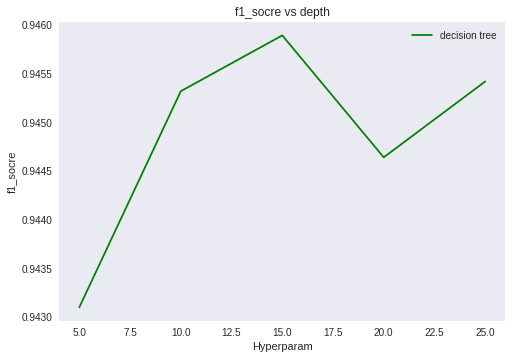

best parameter: {'max_depth': 15}


In [45]:
acc_score= dt_using_grid.cv_results_.get('mean_test_score')
f1_socre = [x for x in acc_score]

hyperparam = depth
plt.plot(hyperparam ,f1_socre ,'g' ,label="decision tree"  )
plt.xlabel('Hyperparam')
plt.ylabel('f1_socre')
plt.title('f1_socre vs depth')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,dt_using_grid.best_params_ )

Test accuracy:  0.9037222222222222
Train accuracy:  0.9302142857142857
              precision    recall  f1-score   support

          -1       0.63      0.36      0.46      2042
           1       0.92      0.97      0.95     15958

   micro avg       0.90      0.90      0.90     18000
   macro avg       0.78      0.67      0.70     18000
weighted avg       0.89      0.90      0.89     18000



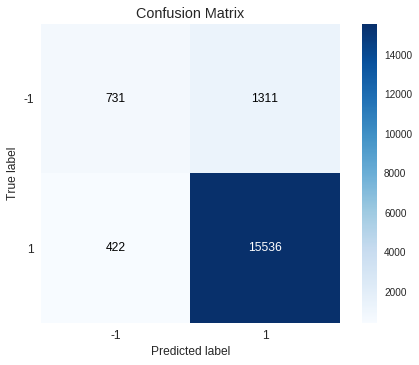

In [46]:


clf = DecisionTreeClassifier(max_depth=dt_using_grid.best_params_['max_depth'], random_state=42)
clf.fit(bow_std_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',clf.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(bow_std_X_train_matrix , Y_train))

test_prediction = clf.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


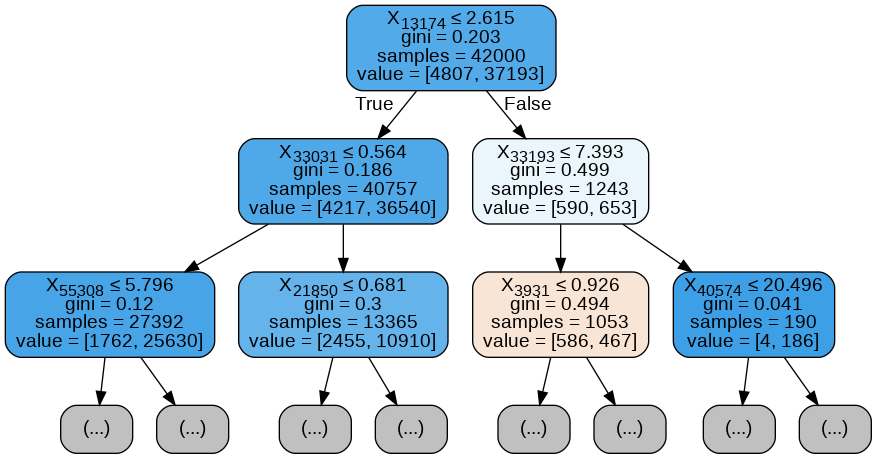

In [47]:
# Source : https://explained.ai/decision-tree-viz/
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, special_characters=True , max_depth = 2 )  

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())


## Important Features

In [48]:
importances = clf.feature_importances_
top_words = np.argsort(importances)[::-1][:20]
names = count_vect.get_feature_names()
for i in range(len(top_words)):
    print(names[top_words[i]])

disappoint
not
great
best
good
love
horribl
delici
worst
not disappoint
wast money
not good
yuck
terribl
excel
bad
aw
perfect
threw
not worth


# TF-IDF

In [49]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)  ,min_df = 5 , max_df = 0.5)
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)

(42000, 56119)
(18000, 56119)


In [0]:
tfidf_std_X_train_matrix = std_data(tf_idf_X_train_matrix)
tfidf_std_X_test_matrix = std_data(tf_idf_X_test_matrix)

In [51]:
# cross validation
clf = DecisionTreeClassifier()
param_grid = {'max_depth':depth} 
tscv = TimeSeriesSplit(n_splits=5) 
dt_using_grid = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1' ,n_jobs = -1)
dt_using_grid.fit(tfidf_std_X_train_matrix,Y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [52]:
# checking cross validation scores
cv_score = list(dt_using_grid.cv_results_.get('mean_test_score'))
hyperparam_values = depth
for i in range(len(cv_score)):
    print('f1_score for depth = ',hyperparam_values[i],'is ',cv_score[i] )

f1_score for depth =  5 is  0.9425900156369946
f1_score for depth =  10 is  0.9454312064267549
f1_score for depth =  15 is  0.9460755187786201
f1_score for depth =  20 is  0.9453865321945858
f1_score for depth =  25 is  0.9453473671292021


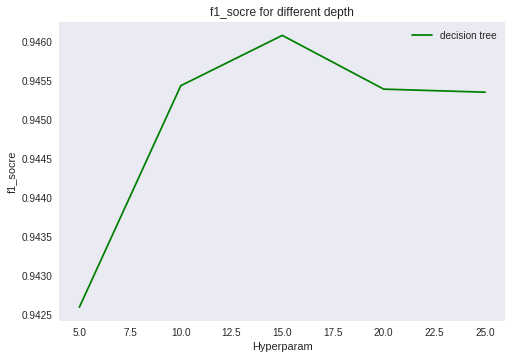

best parameter: {'max_depth': 15}


In [53]:
acc_score= dt_using_grid.cv_results_.get('mean_test_score')
f1_socre = [x for x in acc_score]

hyperparam = depth
plt.plot(hyperparam ,f1_socre ,'g' ,label="decision tree"  )
plt.xlabel('Hyperparam')
plt.ylabel('f1_socre')
plt.title('f1_socre for different depth')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,dt_using_grid.best_params_ )

Test accuracy:  0.9082777777777777
Train accuracy:  0.9338333333333333
              precision    recall  f1-score   support

          -1       0.66      0.40      0.50      2042
           1       0.93      0.97      0.95     15958

   micro avg       0.91      0.91      0.91     18000
   macro avg       0.79      0.69      0.72     18000
weighted avg       0.90      0.91      0.90     18000



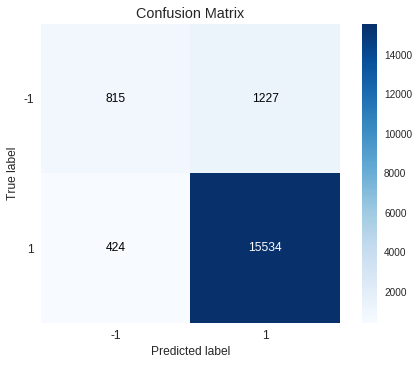

In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = DecisionTreeClassifier(max_depth=dt_using_grid.best_params_['max_depth'], random_state=42)

clf.fit(tfidf_std_X_train_matrix , Y_train)


# test accuracy
print('Test accuracy: ',clf.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = clf.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


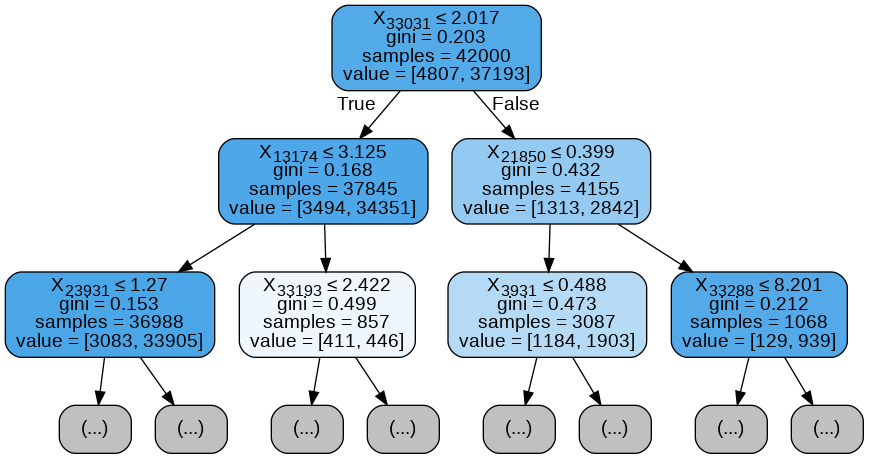

In [55]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, special_characters=True , max_depth = 2 )  

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

## Important Features

In [56]:
importances = clf.feature_importances_
top_words = np.argsort(importances)[::-1][:20]
names = count_vect.get_feature_names()
for i in range(len(top_words)):
    print(names[top_words[i]])

not
disappoint
great
best
horribl
aw
worst
terribl
delici
wast money
good
love
bad
not worth
not disappoint
return
tast
yuck
poor
nice


## Avg Word2Vec

In [0]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)

In [0]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)



In [0]:
# standrizing data
w2vec_std_X_train_matrix = std_data(w2vec_X_train_matrix)
w2vec_std_X_test_matrix = std_data(w2vec_X_test_matrix)

In [60]:
clf = DecisionTreeClassifier()
depth = list(range(5,40,5))
param_grid = {'max_depth':depth} 
tscv = TimeSeriesSplit(n_splits=5) 
dt_using_grid = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1' ,n_jobs = -1)
dt_using_grid.fit(w2vec_std_X_train_matrix,Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   42.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [61]:
# checking cross validation scores
cv_score = list(dt_using_grid.cv_results_.get('mean_test_score'))
hyperparam_values = depth
for i in range(len(cv_score)):
    print('f1_score for depth = ',hyperparam_values[i],'is ',cv_score[i] )

f1_score for depth =  5 is  0.9380022701229644
f1_score for depth =  10 is  0.9268945128995326
f1_score for depth =  15 is  0.9155108588205446
f1_score for depth =  20 is  0.9133144941014997
f1_score for depth =  25 is  0.9120907900957146
f1_score for depth =  30 is  0.9125275825562593
f1_score for depth =  35 is  0.9117583095882458


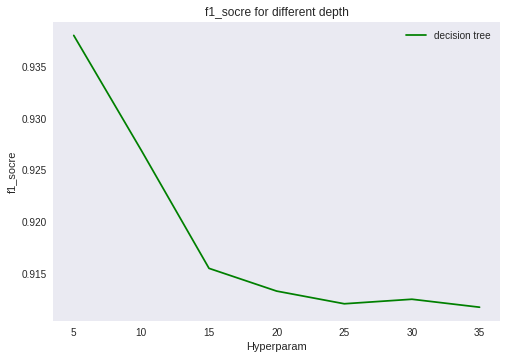

best parameter: {'max_depth': 5}


In [63]:
acc_score= dt_using_grid.cv_results_.get('mean_test_score')
f1_socre = [x for x in acc_score]

hyperparam = depth
plt.plot(hyperparam ,f1_socre ,'g' ,label="decision tree"  )
plt.xlabel('Hyperparam')
plt.ylabel('f1_socre')
plt.title('f1_socre for different depth')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,dt_using_grid.best_params_ )

Test accuracy:  0.8875
Train accuracy:  0.8912380952380953
              precision    recall  f1-score   support

          -1       0.51      0.16      0.25      2042
           1       0.90      0.98      0.94     15958

   micro avg       0.89      0.89      0.89     18000
   macro avg       0.71      0.57      0.59     18000
weighted avg       0.86      0.89      0.86     18000



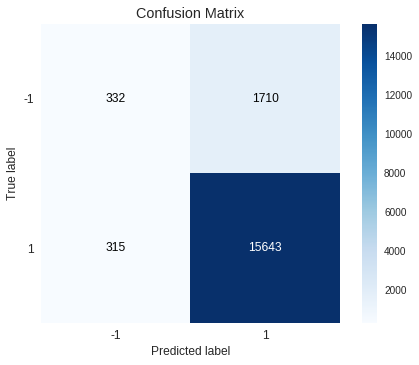

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = DecisionTreeClassifier(max_depth=dt_using_grid.best_params_['max_depth'], random_state=42)
clf.fit(w2vec_std_X_train_matrix , Y_train)
# test accuracy
print('Test accuracy: ',clf.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = clf.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


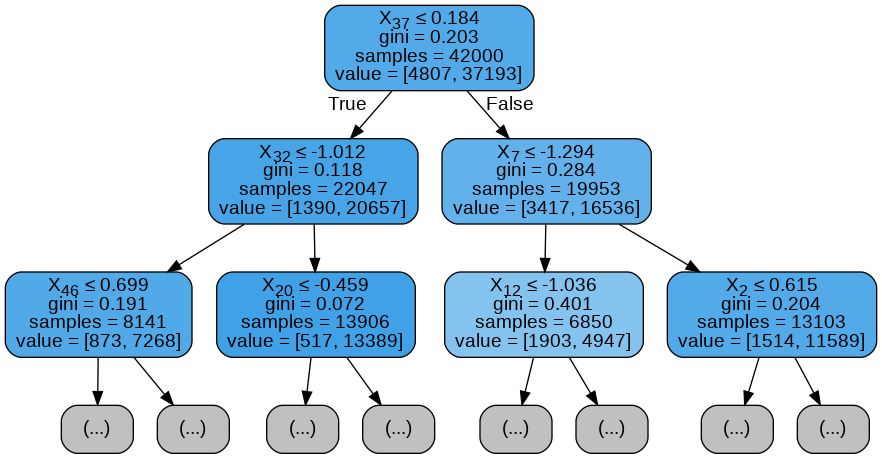

In [65]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, special_characters=True , max_depth = 2 )  

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

# Tf-idf Word2Vec

In [0]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

#w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [0]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1


In [0]:
# standrzing vetors
tfidf_w2vec_std_X_train_matrix = std_data(tfidf_sent_vectors_X_train)
tfidf_w2vec_std_X_test_matrix = std_data(tfidf_sent_vectors_X_test)

In [69]:
# cross validation
clf = DecisionTreeClassifier()
depth = list(range(5,40,5))
param_grid = {'max_depth':depth} 
tscv = TimeSeriesSplit(n_splits=5)
dt_using_grid = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1' ,n_jobs = -1)
dt_using_grid.fit(tfidf_w2vec_std_X_train_matrix,Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [70]:
# checking cross validation scores
cv_score = list(dt_using_grid.cv_results_.get('mean_test_score'))
hyperparam_values = depth
for i in range(len(cv_score)):
    print('f1_score for depth = ',hyperparam_values[i],'is ',cv_score[i] )

f1_score for depth =  5 is  0.9372494446883908
f1_score for depth =  10 is  0.9273113541429114
f1_score for depth =  15 is  0.9154057614375857
f1_score for depth =  20 is  0.9088766378125498
f1_score for depth =  25 is  0.9086808464735885
f1_score for depth =  30 is  0.9081389505847777
f1_score for depth =  35 is  0.9081391377940423


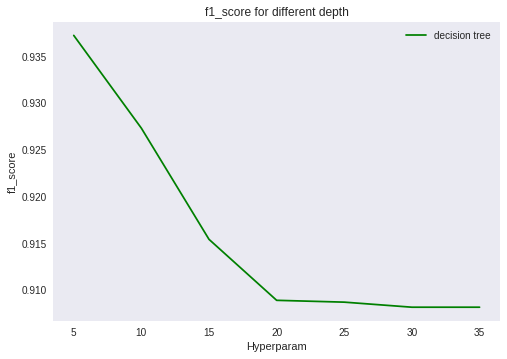

best parameter: {'max_depth': 5}


In [71]:
acc_score= dt_using_grid.cv_results_.get('mean_test_score')
f1_score = [x for x in acc_score]

hyperparam = depth
plt.plot(hyperparam ,f1_score,'g' ,label="decision tree"  )
plt.xlabel('Hyperparam')
plt.ylabel('f1_score')
plt.title('f1_score for different depth')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,dt_using_grid.best_params_ )

Test accuracy:  0.8885555555555555
Train accuracy:  0.8890714285714286
              precision    recall  f1-score   support

          -1       0.55      0.09      0.16      2042
           1       0.89      0.99      0.94     15958

   micro avg       0.89      0.89      0.89     18000
   macro avg       0.72      0.54      0.55     18000
weighted avg       0.86      0.89      0.85     18000



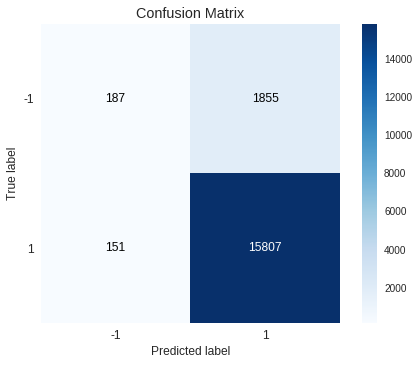

In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = DecisionTreeClassifier(max_depth=dt_using_grid.best_params_['max_depth'], random_state=42)
clf.fit(tfidf_w2vec_std_X_train_matrix , Y_train)
# test accuracy
print('Test accuracy: ',clf.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = clf.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

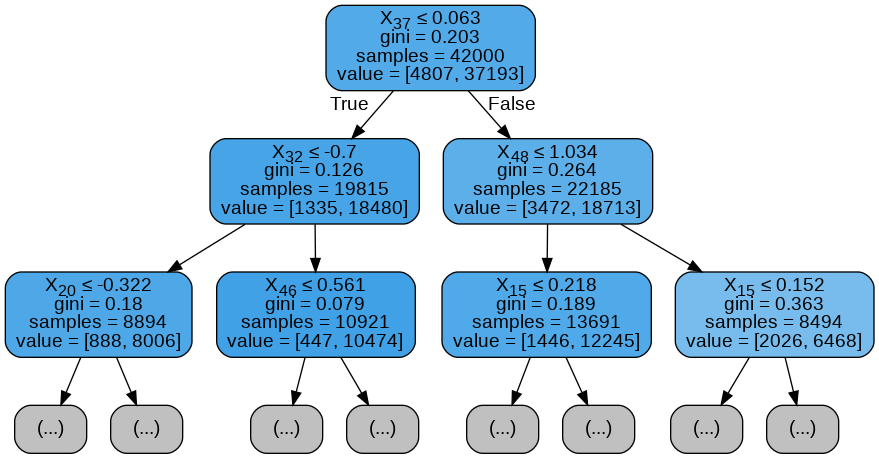

In [73]:
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, special_characters=True , max_depth = 2 )  

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

### Note:
 the features of word2vec and tfidf word2vec vectorization techniques are highly corelated hence directly getting important features is not possible.

## Observation 

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [75]:
x.field_names = ["Vectorizer","Depth of tree", "Test accuracy" , "Train accuracy","f1-score"]
x.add_row(['BOW'  ,'15', '90.37','93.02','0.89' ])

x.add_row(['TF-IDF' ,'15', '90.82','93.38','0.90' ])

x.add_row(['W2vec'  ,'5', '88.97','89.34','0.87' ])


x.add_row(['Tf-Idf W2vec' ,'5', '88.66','88.72','0.85' ])

print(x)

+--------------+---------------+---------------+----------------+----------+
|  Vectorizer  | Depth of tree | Test accuracy | Train accuracy | f1-score |
+--------------+---------------+---------------+----------------+----------+
|     BOW      |       15      |     90.37     |     93.02      |   0.89   |
|    TF-IDF    |       15      |     90.82     |     93.38      |   0.90   |
|    W2vec     |       5       |     88.97     |     89.34      |   0.87   |
| Tf-Idf W2vec |       5       |     88.66     |     88.72      |   0.85   |
+--------------+---------------+---------------+----------------+----------+


#### Conclusion
1. Performance of Decision tree on unseen  text data is quite good.Vectorization techniques like BOW and tf-Idf gave best test results
2. Decision trees can easily get overfit to train samples.
3. To avoid overfitting or underfitting mechanisms like pruning or setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary.
4. Trees can be visualised and hance makes this algorithm very interpretable.
5. decision trees can even handle numerical data quite effiently.